# NhaA membrane protein in a POPE:POPG lipid bilayer (all atom)

**Last executed:** Sep 29, 2021 with MDAnalysis 2.1.0-dev0

**Packages required:** MDAnalysis, MDAnalysisData.


**Packages for visualization:** Matplotlib, SciPy, NGLview.

<style>body {text-align: justify}</style>

In this tutorial, we are going to derive 2D curvature plots in a membrane-protein system. The system comprises one copy of the sodium-proton antiporter NhaA embedded in a lipid bilayer of POPE:POPG 4:1 lipid composition. This system was obtained from an atomistic Molecular Dynamics (MD) simulation using the CHARMM36 force field.

In [1]:
import MDAnalysis as mda
from membrane_curvature.base import MembraneCurvature
from MDAnalysisData import datasets
import matplotlib.pyplot as plt
import more_itertools as mit
import nglview as nv
import numpy as np
from scipy import ndimage


%matplotlib inline

MDAnalysis  : INFO     MDAnalysis 2.1.0-dev0 STARTED logging to 'MDAnalysis.log'


---

This tutorial is divided into six main steps:

[1. Download dataset from MDAnalysisData](#1.-Download-dataset-from-MDAnalysisData)

[2. Load MDA Universe](#2.-Load-MDA-Universe)

[3. Select Atoms of Reference](#3.-Select-Atoms-of-Reference)

[4. Run MembraneCurvature](#4.-Run-MembraneCurvature)

[5. Extract Results](#5.-Extract-Results)

[6. Visualize Results](#6.-Visualize-Results)

---

## 1. Download dataset from MDAnalysisData


Since the [NhaA dataset](https://www.mdanalysis.org/MDAnalysisData/nhaa_equilibrium.html) is available via the [MDAnalysisData](https://www.mdanalysis.org/MDAnalysisData/index.html#) collection, we need an extra step to fetch our dataset using the `datasets.fetch_nhaa_equilibrium()` function. 

You can find more information on how to access files from MDAnalysisData [here](https://www.mdanalysis.org/MDAnalysisData/usage.html#accessing-a-dataset). 

We retrieve our NhaA dataset with (a progress bar will show up here):

In [2]:
NhaA = datasets.fetch_nhaa_equilibrium()

**NOTE:**<br>
Downloading data from MDAnalysisData may take some time. 
Grab a coffee! ☕ 🙃

The resulting Bunch object includes the `DESCR` attribute with a human-readable description of the dataset:

In [3]:
print(NhaA.DESCR)

.. -*- coding: utf-8 -*-

.. _`nhaa-equilibrium-dataset`:

NhaA equilibrium trajectory dataset

Molecular dynamics (MD) trajectory of the NhaA membrane protein in a
POPE:POPG 4:1 model membrane. The equilibrium simulation was performed
in the NPT ensemble at T=300K and P=1 bar. The system was simulated
with Gromacs 5.1.4, using the CHARMM36 force field, the TIP3P explicit
water model, and NaCl at approximately 100 mM concentration. 

Trajectory frames were saved every 100 ps for a total of 500 ns
simulated time. The topology only contains the protein, membrane and
ions (because the water molecules were stripped from the trajectory to
save space).

The topology is contained in the NhaA_non_water.gro file. The trajectory is contained in the NhaA_non_water.xtc file.


Notes
-----

Data set characteristics:

 :size: 1.07 GB
 :number of trajectories: 1
 :number of frames:  5000
 :number of particles: 60702
 :creator: Ian Kenney, Shujie Fan
 :URL:  `10.6084/m9.figshare.7185203.v2 <https://do

Now that we have our NhaA dataset, we are ready to load our Universe. 

## 2. Load MDA Universe

We can load the data stored in `NhaA` into an MDAnalysis Universe with: 

In [4]:
universe = mda.Universe(NhaA.topology, NhaA.trajectory)
universe

<Universe with 60702 atoms>

A quick check of our Universe gives us a better idea of the system used in this tutorial. To check the dimensions of the simulation box, number of residues in the system, and number of frames in the trajectory contained in our Universe, we can run: 

In [5]:
print("Universe info:")
print("\nBox dimensions[x,y,z]: {}." \
      "".format(universe.dimensions[:3]))

print("\n{} residues and {} atoms." \
      "".format(universe.residues.n_residues, universe.residues.n_atoms))

print("\nThe trajectory includes {} frames."\
      "".format(universe.trajectory.n_frames))

Universe info:

Box dimensions[x,y,z]: [119.847176 119.847176  99.499016].

1314 residues and 60702 atoms.

The trajectory includes 5001 frames.


To visualize our system, we can make use of the [NGL Viewer](https://github.com/nglviewer/nglview) and the function `view_system`:

In [6]:
def view_system(system, zoom, surface=False, box=False):

    
    view = nv.show_mdanalysis(system)
    view.add_representation('ball+stick', selection='POPE and .P', radius=2, color="salmon")
    view.add_representation('ball+stick', selection='POPG and .P', radius=2, color="darkcyan")
    view.add_representation('ball+stick', selection='POPG or POPE', radius=0.25, color="grey", opacity=0.05)
    view.add_cartoon("protein", color='navy')
    if surface:
        view.add_surface("protein", color='skyblue', opacity=0.05)

    
    if box:
        view.add_unitcell()
    
    view.camera='orthographic'
    view.control.zoom(zoom)
    view.control.rotate(
         mda.lib.transformations.quaternion_from_euler(
             -np.pi/2, -np.pi/3, np.pi/12, 'rzyz').tolist())
    
    
    return view

In [7]:
view_system(universe, 0.45, surface=True, box=False)

NGLWidget(max_frame=5000)

In the visualization obtained above, we can identify lipid headgroups from POPE molecules coloured in pink, and lipid headgroups from POPG lipids coloured in cyan. The NhaA antiporter is shown in cartoon and surface representation, blue coloured.

Since our system contains protein and membrane, it is useful to identify the lipids and protein separately. We can make use of the MDAnalysis [select_atoms](https://docs.mdanalysis.org/stable/documentation_pages/selections.html#selection-commands) to save the AtomGroups in two different variables:

In [8]:
protein  = universe.select_atoms("protein")
print("\nProtein has {} residues." \
      "".format(protein.n_residues))

lipids  = universe.select_atoms("not protein")
print("\nLipids molecules include {} residues and {} atoms." \
      "".format(lipids.n_residues, lipids.n_atoms))


Protein has 752 residues.

Lipids molecules include 562 residues and 49078 atoms.


---
### NOTE

In this particular membrane-protein example, we find that the NhaA antiporter diffuses in the membrane because the simulation was carried out without position restraints on the protein (See [Appendix 1](#Appendix-1)). As a consequence, the results obtained from MembraneCurvature should not be used as a means to assess membrane curvature induced by the protein or to study properties of lipids around the protein. If the interest is to determine membrane curvature effects driven by protein insertion while the protein is allowed to freely diffuse in the membrane, the current version of MembraneCurvature requires further processing of the input trajectory obtained from the MD simulations. For more details see [Part I](https://ojeda-e.github.io/blog/Considerations-curvature-MD-simulations-PartI/) and [Part II](https://ojeda-e.github.io/blog/Considerations-curvature-MD-simulations-PartII/) of the blog posts that discuss considerations to calculate membrane curvature in different MD simulation setups. 

**This tutorial exercise is intended as an example on how to use the tool but does not provide information about the membrane properties around the protein or induced by the protein.** 

---

## 3. Select Atoms of Reference

The [MembraneCurvature algorithm](https://membrane-curvature.readthedocs.io/en/latest/source/pages/Algorithm.html) uses an `AtomGroup` as a reference to derive surfaces. In the NhaA system, we can use the phospholipid headgroups from the POPE and POPG molecules as an `AtomGroup` of reference. Given that the NhaA system was obtained from an all atom MD simulation, for our `AtomGroup` we are going to choose the phosphate phosphorus atoms. 

Then, we can select the atoms with the name `P` in our Universe with:

In [9]:
P_headgroups = universe.select_atoms('name P')

The AtomGroup `P_headgroups`, however, include the phosphorus atoms of all the lipids in our system instead of the individual leaflets. Since MembraneCurvature calculates curvature from a single surface, we should select an `AtomGroup` for lower and upper leaflet, separately.

Because we don't know the details of our system and we need to identify the residues in each leaflet of the bilayer, we can use the [leaflet MDAnalysis module](https://docs.mdanalysis.org/2.0.0-dev0/documentation_pages/analysis/leaflet.html) to automatically identify them.

To use the MDAnalysis LeafletFinder we do: 

In [10]:
from MDAnalysis.analysis.leaflet import LeafletFinder

L_nhaa = LeafletFinder(universe, 'name P', cutoff=20)

nhaa_upper_leaflet = L_nhaa.groups(0) # upper leaflet
nhaa_lower_leaflet = L_nhaa.groups(1) # lower leafet

In [11]:
type(nhaa_upper_leaflet)

MDAnalysis.core.groups.AtomGroup

Here, the variables `nhaa_upper_leaflet` and `nhaa_lower_leaflet` are `AtomGroups`. 

Let's check the residues in each leaflet:

In [12]:
nhaa_lower_leaflet.residues.resids

array([425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437,
       438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
       451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,
       620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632,
       633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645,
       646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658,
       659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671,
       672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684,
       685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697,
       698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710,
       711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723,
       724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736,
       737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749,
       750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 76

In [13]:
nhaa_upper_leaflet.residues.resids

array([386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,
       399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424,
       464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,
       477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502,
       503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515,
       516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528,
       529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541,
       542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554,
       555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567,
       568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580,
       581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593,
       594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 60

Then, we can select the phosphorus headgroup atoms from each leaflet:

In [14]:
leaflets = ['Lower', 'Upper']

nhaa_upper_leaflet_P = nhaa_upper_leaflet.select_atoms("name P")
nhaa_lower_leaflet_P = nhaa_lower_leaflet.select_atoms("name P")


for name, new_lf in zip(leaflets,[nhaa_lower_leaflet_P, nhaa_upper_leaflet_P]):
    print("{} leaflet includes {} elements.".format(name, 
                                                    len(new_lf)))

Lower leaflet includes 195 elements.
Upper leaflet includes 195 elements.


Similarly, we can select the selection string from the atomgroup, and turn them into a human readable string.

In [15]:
sel_upper = " ".join([str(r) for r in nhaa_upper_leaflet.residues.resids])
sel_lower = " ".join([str(r) for r in nhaa_lower_leaflet.residues.resids])

upper_string = "resid {} and name P".format(sel_upper)
lower_string = "resid {} and name P".format(sel_lower)

The selection `sel_upper` and `sel_lower` will be useful to visualize the selections later on.

---
**NOTE:**<br>

An alternative approach to select residues for each leaflet can be found in [Appendix 2](#Appendix-2).

---

To double-check we have the right residues in each leaflet, we can visually check the selection of atoms using [NGL Viewer](https://github.com/nglviewer/nglview). We use the function `color_by_leaflet` to visualize the `AtomGroup` for each leaflet according to the selection found above. 



In [16]:
def color_by_leaflet(system, sel_up, sel_lw, zoom, box=False):

    
    view = nv.show_mdanalysis(system)
    
    view.add_ball_and_stick(sel_up,
                            radius=2.00, 
                            color="orange")
    

    view.add_ball_and_stick(sel_lw,
                            radius=2.00, 
                            color="green")
    
    
    if box == True:
        view.add_unitcell()
    
    view.camera='orthographic'
    view.control.zoom(zoom)
    view.control.rotate(
         mda.lib.transformations.quaternion_from_euler(
             -np.pi/2, np.pi/3, np.pi/12, 'rzyz').tolist())
    
    
    return view

In [17]:
color_by_leaflet(nhaa_upper_leaflet+nhaa_lower_leaflet, sel_upper, sel_lower, 0.05, box=True)

NGLWidget(max_frame=5000)

In the widget above we identify the selection of lipid headgroups in the lower (green coloured) and the upper leaflet (orange coloured). Each leaflet is one AtomGroup, which will be used as a reference to derive surfaces and calculate curvature. 

**NOTE:** <br>
**Validating that your leaflet selection is correct is a fundamental step to run MembraneCurvature.** Before running, double-check the selections do not include mixed residues between leaflets. Keep in mind that incorrect or incomplete selection in the `AtomGroup` of reference will therefore provide inaccurate calculations of membrane curvature.

Now that we have identified the `AtomGroup` of reference, we can run MembraneCurvature.

## 4. Run MembraneCurvature

`MembraneCurvature` is a Python class that performs multiframe analyses to derive surfaces from the `AtomGroup` of reference. From the derived surface, `MembraneCurvature` calculates mean and Gaussian curvature per frame and their respective average over frames.

```
MembraneCurvature(universe,         # universe
                  select='name P',  # selection of reference
                  n_x_bins=6,       # number of bins in the x dimension
                  n_y_bins=6,       # number of bins in the y_dimension
                  wrap=True)        # wrap coordinates to keep atoms in the main unit cell
```

To use MembraneCurvature, we have four main parameters to provide:

* **Universe**: The Universe that contains our system of interest. In this tutorial, our Universe comprises a protein embedded in POPE POPG lipid bilayer, as described in [Section 2](#2.-Load-MDA-Universe).

* **Atom selection** (`select`): This is a key parameter to run MembraneCurvature. Based on this selection, surfaces will be derived for every frame in the trajectory. Simultaneously, curvature will be calculated from the derived surface. In this tutorial, we selected the leaflets contained in our Universe as shown in [3 Select Atoms of Reference](#3.-Select-Atoms-of-Reference).

- **Number of bins** (`n_x_bins`, `n_y_bins`): This parameter will determine how many bins are assigned to the grid in each dimension. In Membrane Curvature, the dimensions of the grid are determined by the size of the simulation box contained in the Universe. The grid comprises n_x_bins x n_y_bins number of bins. Choosing the number of bins is also important. Choosing too many bins may introduce undefined values in the grid built by the MembraneCurvature algorithm. On the other hand, a very low number of bins may result in significant loss of information. We recommend taking bins of size ~20A. In [Section 2](#2-Load-MDA-Universe) we found that our Universe has dimensions ~120 x 120 Å. Therefore, in this tutorial we are going to use `n_x_bins=n_y_bins=6`. 


- **Coordinate wrapping** (`wrap`): Applying coordinate wrapping is useful when we have atoms falling outside the boundaries of the simulation box. Since this is a raw trajectory, and we want to have a high number of lipid headgroups to derive the surface, we use `wrap=True` to put all the atoms in the primary unit cell. 




With a clear definition of the `AtomGroup` associated to each leaflet and the parameters needed to calculate membrane curvature in our system, we are ready to run MembraneCurvature. 

Running MembraneCurvature for the NhaA-membrane system is expected to take less than a minute for each leaflet. 

We run MembraneCurvature for the upper leaflet with:

In [18]:
curvature_upper_leaflet = MembraneCurvature(universe, 
                                            select=upper_string,
                                            n_x_bins=6, 
                                            n_y_bins=6,
                                            wrap=True).run()

MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
/Users/estefania/python_playground/membrane-curvature/membrane_curvature/surface.py:101: UserWarning: Atom outside grid boundaries. Skipping atom.
  warnings.warn(msg)
MDAnalysis.analysis.base: INFO     Finishing up


As detailed in the [Algorithm](https://membrane-curvature.readthedocs.io/en/latest/source/pages/Algorithm.html#set-grid) page, MembraneCurvature uses the dimensions of the box to set the dimensions of the grid. The cell above shows a warning message indicating that one of the elements in the AtomGroup of reference has negative coordinates, hence falling outside the grid boundaries established by the dimensions of the NhaA-membrane simulation box (~120 Å x 60 Å divided into 36 bins). 

The warning tells the user that the number of atoms used in the upper leaflet is reduced. Instead of deriving a surface from the 195 elements included in the `nhaa_upper_leaflet_P` selection, the surface uses 194 elements in the AtomGroup. Deriving a surface with sufficient sampling will reduce or eliminate this warning.


Similarly, for the lower leaflet, we run MembraneCurvature with:

In [19]:
curvature_lower_leaflet = MembraneCurvature(universe, 
                                            select=lower_string, 
                                            n_x_bins=6, 
                                            n_y_bins=6,
                                            
                                            wrap=True).run()

MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up



## 5. Extract Results

`MembraneCurvature` stores the calculation of surface and curvature in the `.results` attribute. We can find two different types of results: 

* **Multiframe**
MembraneCurvature derives the surface from the `AtomGroup` of reference, as well as mean and Gaussian curvature, for every frame in the trajectory. 
 
```
curvature_upper_leaflet.results.z_surface
curvature_upper_leaflet.results.mean_curvature
curvature_upper_leaflet.results.gaussian_curvature
```

* **Average over frames**
The derived surface, and calculated mean and Gaussian curvature are averaged over the `n_frames` of the trajectory.

```
curvature_upper_leaflet.results.average_z_surface
curvature_upper_leaflet.results.average_mean
curvature_upper_leaflet.results.average_gaussian
```

In this tutorial, we are going to extract the **average over frames** results for surface, mean and Gaussian curvature. You can find an example of MembraneCurvature using the **Multiframe** results in the [Membrane-only system tutorial](https://membrane-curvature.readthedocs.io/en/latest/source/pages/Curvature_membrane-only_systems.html).

### 5.1 Surface

The surfaces associated to upper and lower leaflet are derived from the _z_ positions of the elements in the AtomGroup of reference. For more details see [get_z_surface()](https://membrane-curvature.readthedocs.io/en/latest/api/surface.html#membrane_curvature.surface.get_z_surface) in API documentation.

In this tutorial we assign as an AtomGroup of reference the phosphorus atoms of the lipids molecules in each leaflet. We can check the surface derived from the lipid headgroups in the upper leaflet with:

In [20]:
nhaa_surface_upper_leaflet = curvature_upper_leaflet.results.average_z_surface

It's important to note that `surface_upper_leaflet` is an array of shape (`n_x_bins`, `n_y_bins`). The values in the grid contains the averaged Z coordinate value of the lipid headgroups for a given .

We can check the shape of the resulting array doing:

In [21]:
nhaa_surface_upper_leaflet.shape

(6, 6)

A shape of `(6,6)` means that we have a total of 36 elements (bins) in the grid. The values stored in each element of `nhaa_surface_upper_leaflet` is the averaged $Z$ coordinate of the lipid headgroups in that particular bin. 

Since we are retriving the average z surface from the upper leaflet, the shape of the array indicates that the grid used to derive the surface was divided into 6 bins in both $x$ and $y$ dimensions.

Similarly, for the lower leaflet we run:

In [22]:
nhaa_surface_lower_leaflet = curvature_lower_leaflet.results.average_z_surface

### 5.2 Curvature

The calculated values of curvature averaged over frames are stored in the attributes `.results.average_mean_curvature` and
`results.average_gaussian_curvature`. These arrays contain the computed values of mean ($H$) and Gaussian ($K$) curvature averaged over the `n_frames` of the trajectory. For details of the calculation of mean and Gaussian curvature see the [Curvature API](https://membrane-curvature.readthedocs.io/en/latest/api/curvature.html#functions) documentation. It's also important to keep in mind that the units of mean curvature is 1/lenght (Å$^{-1}$), and the units of Gaussian curvature is 1/[length^2] (Å$^{-2}$). 

#### Mean Curvature ($H$)

We can save the calculated values (`np.ndarrays`) of membrane curvature for each leaflet in two new variables called `nhaa_mean_upper_leaflet` and `nhaa_mean_lower_leaflet`: 

In [23]:
nhaa_mean_upper_leaflet = curvature_upper_leaflet.results.average_mean

In [24]:
nhaa_mean_lower_leaflet = curvature_lower_leaflet.results.average_mean

Since we are extracting the results of averaged mean curvature, the shape of these arrays is simply `(n_x_bins, n_y_bins)`:

In [25]:
nhaa_mean_upper_leaflet.shape

(6, 6)

In `nhaa_mean_upper_leaflet`, each element of the array correspond to the value of mean curvature in the respective bin.

#### Gaussian Curvature ($K$)

Since the information of the averaged Gaussian curvature is stored in the `results.average_gaussian` attribute, we can store the values of $K$ in another two variables, `nhaa_gaussian_upper_leaflet` and `nhaa_gaussian_lower_leaflet`:

In [26]:
nhaa_gaussian_upper_leaflet = curvature_upper_leaflet.results.average_gaussian

In [27]:
nhaa_gaussian_lower_leaflet = curvature_lower_leaflet.results.average_gaussian

Now that we have extracted the data containing values of surface, mean and Gaussian curvature, we can proceed to visualize the results.

## 6. Visualize Results

There are two main approaches to visualize results from MembraneCurvature.

[Contour plots](#Contours-plots)

[Imshow plots](#Imshow-plots)


### Contours plots

To visualize the results obtained from the MembraneCurvature we can use `contourf` from [Matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html). By using `contourf` to plot MembraneCurvature results, we gather all the points of equal value and the region enclosed by that set of points is coloured according to a colormap of preference.

To illustrate the most basic plot we can generate using contours, we are going to plot the averaged mean curvature obtained for the lower leaflet. We do:

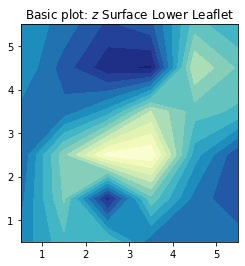

In [28]:
fig, ax = plt.subplots(1,1)
ax.contourf(nhaa_surface_lower_leaflet, cmap='YlGnBu_r', origin='lower', levels=15)
ax.set_aspect('equal')
ax.set_title('Basic plot: $z$ Surface Lower Leaflet')
plt.show()

In this basic plot to visualize the averaged $z$ surface, there are several rough edges in the contours, and it lacks a colorbar for reference. A more elaborate way to plot contours uses the [zoom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html#scipy.ndimage.zoom) function from the [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html) package for multidimensional processing. The `zoom` interpolation is used to smooth the contours.

Hence, a smooth contour plot of mean curvature can be generated with the function `plot_contours` as follows: 

In [29]:
from scipy import ndimage

def plot_contours(results, label, levels_, cm):
    """
    Function used to plot contours of MembraneCurvature results. 
    User can determine number of contour lines / regions (levels),
    label of the colorbar (label) and colormap (cmap).

    Parameters
    ----------
    results: list
        List with results by leaflets as elements [lower_leaflet, upper_leaflet]
    label: str
        Label to add to colorbar. 
    levels: int
        Determines number of contour lines.
    cmap: str
        Colormap to use in plot.
    
    """
    
    fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(4,3.5), dpi=200)
    max_ = np.max(results)
    for ax, rs, lf in zip((ax1, ax2), results, leaflets):
        rs = ndimage.zoom(rs, 3, mode='wrap', order=1)
        if np.min(rs) < 0 < np.max(rs):
            levs = np.linspace(-max_, max_, levels_)
            im = ax.contourf(rs, cmap=cm, origin='lower', levels=levs, alpha=0.95, vmin=-max_, vmax=max_)
            tcs = [-max_, 0, max_]
        else:
            levs = np.linspace(int(np.min(rs)), round(np.max(rs)), levels_)
            im = ax.contourf(rs, cmap=cm, origin='lower', levels=levs, alpha=0.95,  vmin=int(np.min(rs)), vmax=round(np.max(rs)))
            tcs = [int(np.min(rs)), round(np.max(rs))]
            
        ax.set_aspect('equal')
        ax.set_title('{} Leaflet'.format(lf), fontsize=6)
        ax.axis('off')
        cbar = plt.colorbar(im, ticks=tcs, orientation='horizontal', ax=ax, shrink=0.7, aspect=10, pad=0.05)
        cbar.ax.tick_params(labelsize=4, width=0.5)
        cbar.set_label(label, fontsize=6, labelpad=2) 
    return

Since lipid composition between leaflets is commonly asymmetric, the function `plot_contours` also enables direct comparison of the results obtained from MembraneCurvature between leaflets. Note that there are four arguments in the `plot_contours` function. The first one is a list that contains the results of curvature by leaflet, the second one is the label to attach to the colorbar, the third one determines the number of contours in the plot, and the fourth one is the colormap to use in the plot.


To compare the surfaces derived from the each leaflet, we can use `plot_contours` as in:

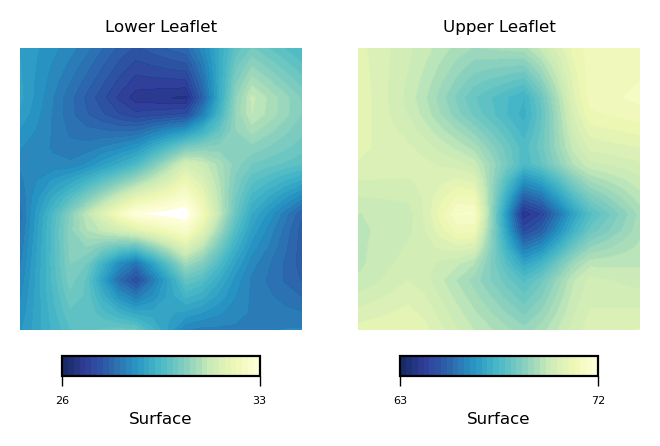

In [30]:
plot_contours([nhaa_surface_lower_leaflet, nhaa_surface_upper_leaflet], 'Surface', 35, 'YlGnBu_r')

Similarly, we can plot mean curvature using the `plot_contours` function:

In [31]:
mean_curvs = [nhaa_mean_lower_leaflet, nhaa_mean_upper_leaflet]

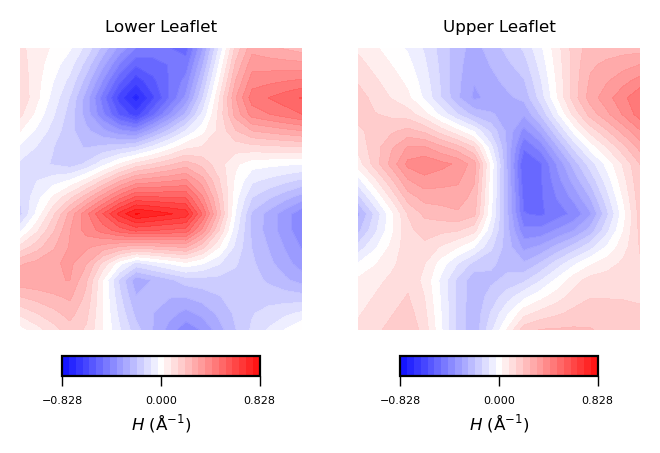

In [32]:
plot_contours(mean_curvs, "$H$ (Å$^{-1}$)", 30, "bwr")

--- 
**NOTE**:<br>

As mentioned before, in the MD system considered in this tutorial we observe protein diffusion. Therefore, the results of mean and Gaussian here obtained provide information about the membrane while averaging over protein diffusion instead of the properties of the lipids around the protein or membrane curvature driven by protein insertion. To evaluate properties of the local environment around the protein or membrane curvature as an effect of protein insertion, further trajectory processing is required. (See [Note](#NOTE) in Section 2)

---

Mean curvature ($H$) gives information about the "inverted shape" of the surface. Positive mean curvature indicates valleys or convexe regions in the membrane, while negative mean curvature indicates peaks or concave regions. $H=0$ means flat curvature.

Hence, from the obtained contour plot of mean curvature we can identify:

* In the lower leaflet, from the bottom left to the upper right corner of the simulation box, a region of positive curvature (red coloured).

* Overall, positive curvature dominates in the upper leaflet. However, there is a clear domain of negative curvature in the central region of the leaflet.

* By comparing the two plots, the curvature induced by NhaA in the lower leaflet is stronger. 

Similar to the approach used for mean curvature, to plot the results of averaged Gaussian curvature we first create the list of curvatures:

In [33]:
gaussian_curvs = [nhaa_gaussian_lower_leaflet, nhaa_gaussian_upper_leaflet]

And then call the `plot_contours` function:

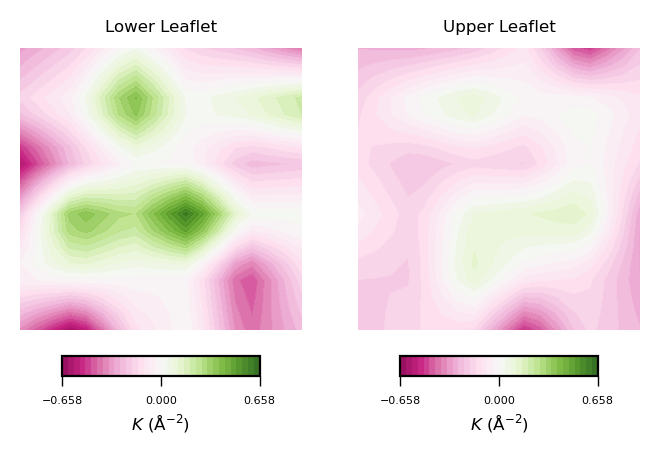

In [34]:
plot_contours(gaussian_curvs, "$K$ (Å$^{-2}$)", 35, "PiYG")

To read plots of Gaussian curvature, a rule of thumb is: negative Gaussian curvature represents saddle points, positive Gaussian curvature represents points of concave regions. Generally speaking, Gaussian curvature is associated to the elasticity of the membrane. 

From the obtained contour plot of Gaussian curvature, we can identify:

* Regions of positive Gaussian curvature (coloured in green) dominate in the lower leaflet.

* There are three main spots of positive Gaussian curvature (green coloured regions) in the lower leaflet. 

* The upper leaflet shows less flexibility during the simulation. 

For a nice graphical review on curvature, including mean and Gaussian curvature, check [this](https://www.researchgate.net/figure/Measures-of-surface-curvature-a-The-principal-curvatures-are-calculated-from-the_fig6_321165318) link.

The results obtained of surface, mean crvature, and Gaussian curvature can be also be visualized per leaflet using the function `plots_by_leaflet`.

In [35]:

def plots_by_leaflet(results):
    """
    Generate figure with of surface, $H$ and $K$
    as subplots.
    """
    
    
    cms=["YlGnBu_r", "bwr", "PiYG"]
    units=['$Z$ $(\AA)$','$H$ (Å$^{-1})$', '$K$ (Å$^{-2})$']
    titles = ['Surface', 'Mean Curvature', 'Gaussian Curvature']

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(7,4), dpi=200)
    for ax, mc, title, cm, unit in zip((ax1, ax2, ax3), results, titles, cms, units):
        mc = ndimage.zoom(mc,3, mode='wrap', order=1)
        bound = max(abs(np.min(mc)), abs(np.max(mc)))
        if np.min(mc) < 0 < np.max(mc):
            im = ax.contourf(mc, cmap=cm, levels=40, alpha=0.95, vmin=-bound, vmax=+bound)
            tcs = [np.min(mc), 0, np.max(mc)]
        else:
            im = ax.contourf(mc, cmap=cm, levels=40, alpha=0.95)
        ax.set_aspect('equal')
        ax.set_title(title, fontsize=12)
        ax.axis('off')
        cbar=plt.colorbar(im, ticks=[np.min(mc), 0, np.max(mc)] if np.min(mc) < 0 < np.max(mc) else [np.min(mc), np.max(mc)], ax=ax, orientation='horizontal', pad=0.05, aspect=15)
        cbar.ax.tick_params(labelsize=7, width=0.5)
        cbar.set_label(unit, fontsize=9, labelpad=2) 
    plt.tight_layout()

In [36]:
results = [nhaa_surface_lower_leaflet, 
           nhaa_mean_lower_leaflet, 
           nhaa_gaussian_lower_leaflet] 

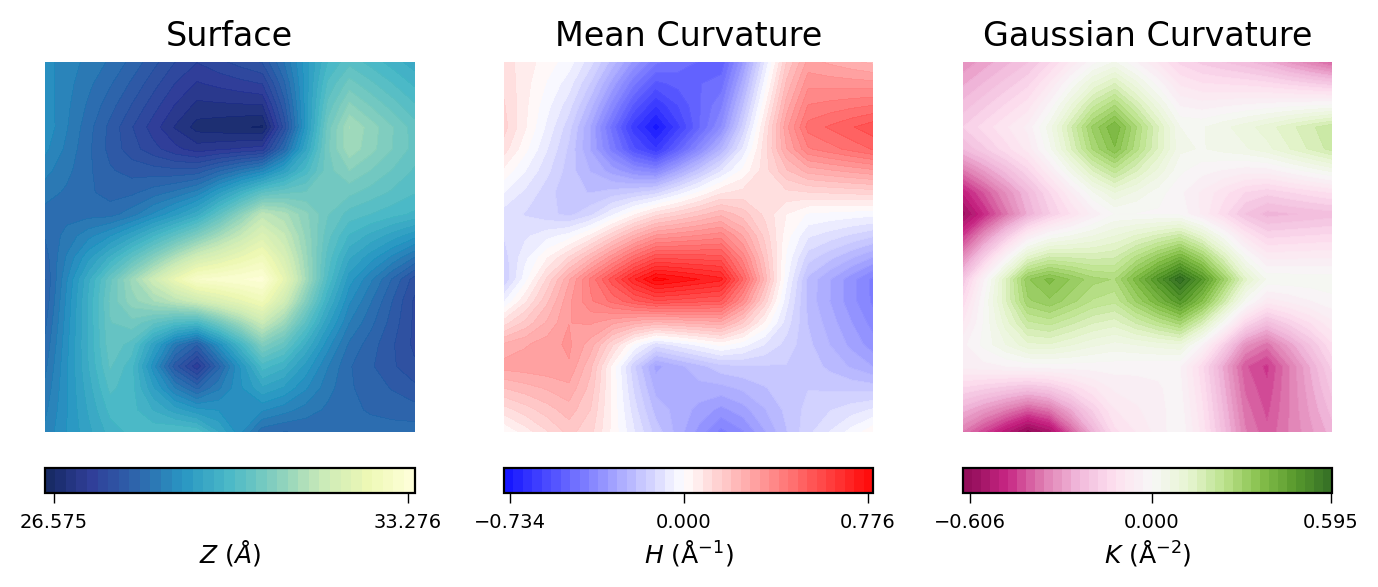

In [37]:
plots_by_leaflet(results)

The plot above allow us to directly compare the averaged results obtained for the upper leaflet using MembraneCurvature.

### Imshow plots

As an alternative, we can also plot results from MembraneCurvature via [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html). By using imshow, the visualization is generated by plotting each element of the array in a matrix of `m x n` elements and according to a colormap of reference. In the case of MembraneCurvature, the matrix has the same shape as the arrays stored in the `.results` attributes. So it will be a matrix of `n_x_bins, n_y_bins`. The color of each square is determined by the value of the corresponding array element and the color map used. 

The most basic plot using `imshow` to plot the surface in the lower leaflet can be obtained by:

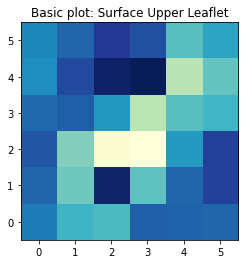

In [38]:
fig, ax = plt.subplots(1,1)
ax.imshow(nhaa_surface_lower_leaflet, cmap='YlGnBu_r', origin='lower')
ax.set_aspect('equal')
ax.set_title('Basic plot: Surface Upper Leaflet')
plt.show()

The basic `imshow` plot to visualize the surface in the upper leaflet show a different color for each bin in the array. From this plot is very easy to identify we have 12 bins in each dimension.

This plot, however, is not visually pleasing. We can improve an `imshow` plot by adding an interpolation method. For consistency with the [**contour**](#Contours) plots, we are going to use the `'gaussian'` interpolation method. For more inteprolation methods you can read the [imshow interpolation Matplotlib docs](https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html).

Hence, we can generate better `imshow` plots by doing something like:

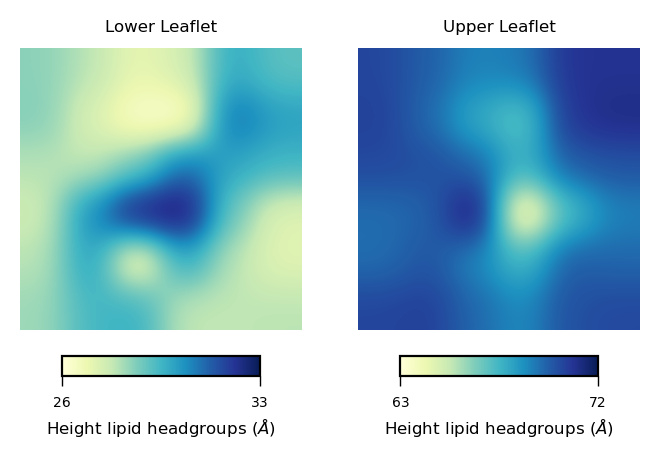

In [39]:
surfaces = [nhaa_surface_lower_leaflet,  # surface in lower leaflet from frame=0 
            nhaa_surface_upper_leaflet]  # surface fn upper leaflet from frame=0


fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(4,3.5), dpi=200)
for ax, surfs, lf in zip((ax1, ax2), surfaces, leaflets):
    im = ax.imshow(surfs, interpolation='gaussian', cmap='YlGnBu', origin='lower')
    ax.set_aspect('equal')
    ax.set_title('{} Leaflet'.format(lf), fontsize=6)
    ax.axis('off')
    cbar = plt.colorbar(im, ticks=[surfs.min(), surfs.max()], orientation='horizontal', ax=ax, shrink=0.7, aspect=10, pad=0.05)
    cbar.set_ticklabels([int(surfs.min()), int(surfs.max())])
    cbar.ax.tick_params(labelsize=5, width=0.5)
    cbar.set_label("Height lipid headgroups (${\AA}$)", fontsize=6, labelpad=2) 

To plot curvature using `imshow`, we can define a function to plot each leaflet based on this plot:

In [40]:
def plot_by_leaflet(results, label, cm):
    fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(4,2), dpi=200)
    for ax, rs, lf in zip((ax1, ax2), results, leaflets):
        rs = ndimage.zoom(rs, 4, mode='wrap')
        im = ax.imshow(rs, interpolation='gaussian', cmap=cm, origin='lower', alpha=0.8)
        ax.set_aspect('equal')
        ax.set_title('{} Leaflet'.format(lf), fontsize=6)
        ax.axis('off')
        cbar = plt.colorbar(im, ticks=[], orientation='horizontal', ax=ax, shrink=0.7)
        cbar.set_label(label, fontsize=6, labelpad=2) 
    return


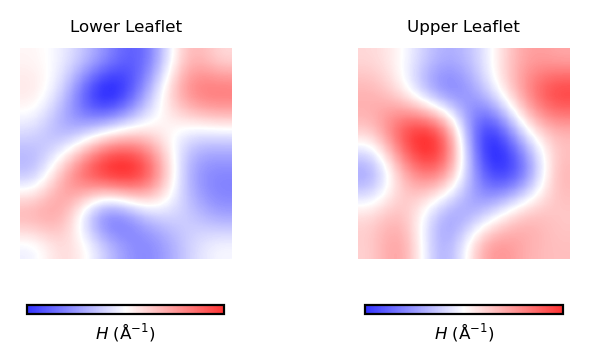

In [41]:
plot_by_leaflet(mean_curvs, "$H$ (Å$^{-1}$)", "bwr")

Similarly, we can plot the values stored in the variables `nhaa_gaussian_lower_leaflet` and `nhaa_gaussian_upper_leaflet` using `imshow`. We can plot the results using the function `plot_by_leaflet`.

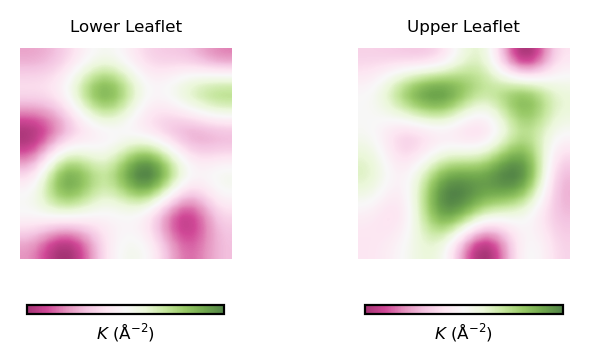

In [42]:
plot_by_leaflet(gaussian_curvs, "$K$ (Å$^{-2}$)", "PiYG")

---

## Appendix 1

To determine if the NhaA antiporter diffusses along the membrane, we can make use of the [MSD MDAnalysis analysis module](https://docs.mdanalysis.org/2.0.0-dev0/documentation_pages/analysis/msd.html?highlight=msd).

In [43]:
import MDAnalysis.analysis.msd as msd

Given that our universe contains a membrane-protein system, we can calculate the Mean Square Displacement (MSD) of the protein by using the class EinsteinMSD with:

In [44]:
MSD = msd.EinsteinMSD(universe, 
                      select='name CA', # Select the backbone of the protein
                      msd_type='xy', # select plane xy 
                      fft=True)
MSD.run()

MDAnalysis.analysis.base: INFO     Choosing frames to analyze
MDAnalysis.analysis.base: INFO     Starting preparation
MDAnalysis.analysis.base: INFO     Finishing up


To access the results from the MSD analysis, we check the `.results` attribute of `MSD`:

In [45]:
msd = MSD.results.timeseries

Additionaly, we can define the lagtimes based on the number of frames included in the trajectory. This will help to plot the MSD results more conveniently.

In [46]:
n_frames = MSD.n_frames
lagtimes = np.arange(n_frames)

And we define the `plot_msd_protein` function to plot the MSD of the protein along the `n_frames` of the simulation:

In [47]:
def plot_msd_protein(lagtime, msd):
    fig, ax = plt.subplots()
    ax.plot(lagtimes, msd, label='Protein CA')
    plt.legend()
    plt.xlabel('Lagtime $\Delta t$')
    plt.ylabel('MSD')
    plt.grid()
    plt.show()

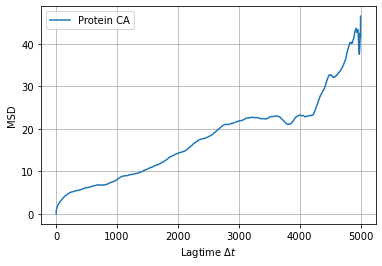

In [48]:
plot_msd_protein(lagtimes, msd)

The plot above illustrates the MSD of the protein backbone with respect to the lag-time. It means that the backbone of the protein diffuses in the plane of the membrane (_xy_ plane), and therefore, additional trajectory processing is required to investigate membrane curvature around the protein as well as curvature induced by protein insertion.

---

## Appendix 2

In section [3. Select Atoms of Reference](#3.-Select-Atoms-of-Reference), we used the [leaflet MDAnalysis module](https://docs.mdanalysis.org/2.0.0-dev0/documentation_pages/analysis/leaflet.html) to automatically identify residues in each leaflet.

We ran:

In [49]:
L_nhaa = LeafletFinder(universe, 'name P', cutoff=20)

nhaa_upper_leaflet = L_nhaa.groups(0) # upper leaflet
nhaa_lower_leaflet = L_nhaa.groups(1) # lower leafet

which allow us to obtain the atom residues in each leaflet.

In [50]:
nhaa_lower_leaflet.residues.resids

array([425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437,
       438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
       451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,
       620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632,
       633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645,
       646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658,
       659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671,
       672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684,
       685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697,
       698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710,
       711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723,
       724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736,
       737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749,
       750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 76

In [51]:
nhaa_upper_leaflet.residues.resids

array([386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,
       399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424,
       464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,
       477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502,
       503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515,
       516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528,
       529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541,
       542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554,
       555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567,
       568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580,
       581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593,
       594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 60

However, the list of residues shown above are not consecutive. For example, residues in the lower leafet (stored in `nhaa_lower_leafet`), go from 425 to 463, and from 620 to 775. 

An alternative approach to automatically identify the residues from each leaflet is by using [split](https://numpy.org/doc/stable/reference/generated/numpy.split.html) and [ediff1d](https://numpy.org/doc/stable/reference/generated/numpy.ediff1d.html?highlight=ediff1d#numpy.ediff1d) from the NumPy package. With `np.split` and `np.ediff1d` we can store the atom indexes of each leaflet in the `membrane_indexes` dictionary as in:

In [52]:
leaflets = ["Lower", "Upper"]

lfs = [nhaa_lower_leaflet,
       nhaa_upper_leaflet]

membrane_indexes = {key:[] for key in leaflets}

for leaflet, index in zip(leaflets, range(len(leaflets))):
    membrane_indexes[leaflet] = np.split(lfs[index].resids, np.where(np.ediff1d(lfs[index].residues.resids) > 1)[0] + 1)

where `'Lower'` and `'Upper'` are the names assigned to the keys of the `membrane_indexes` dictionary. 

In [53]:
membrane_indexes

{'Lower': [array([425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437,
         438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
         451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463]),
  array([620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632,
         633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645,
         646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658,
         659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671,
         672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684,
         685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697,
         698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710,
         711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723,
         724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736,
         737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749,
         750, 751, 752, 753

Now we can print the range for each leaflet:

In [54]:
for lf in leaflets:
    print("\n{} leaflet:".format(lf))
    for index in membrane_indexes[lf]:
        print("resid {}-{} ".format(index[0], 
                                     index[-1]))



Lower leaflet:
resid 425-463 
resid 620-775 

Upper leaflet:
resid 386-424 
resid 464-619 


---